In [46]:
# import statements
import numpy as np
import pandas as pd
import pybaseball as pyball
import matplotlib.pyplot as plt
import math

pyball.cache.enable()

In [2]:
# pulling in statcast data
statcast_2021_raw = pyball.statcast('2021-04-01', '2021-10-04')

# pull in fences data from CSV
fences = pd.read_csv('/Users/wrowley/Desktop/python-projects/little-league/fence_heights_complete.csv')

This is a large query, it may take a moment to complete


100%|██████████| 187/187 [00:07<00:00, 24.17it/s]


In [3]:
# data cleaning
hit_balls = statcast_2021_raw[statcast_2021_raw['description'] == 'hit_into_play']
potential_hrs = hit_balls[hit_balls['hit_distance_sc'] > 300].copy()
potential_hrs['uID'] = range(1, len(potential_hrs) + 1)
potential_hrs['actual_hr'] = potential_hrs['events'].copy() == 'home_run'

# selecting just the columns we need
potential_hrs = potential_hrs[['uID',
                               'launch_speed', 
                               'launch_angle',
                               'events',
                               'plate_z',
                               'hit_distance_sc', 
                               'hc_x', 
                               'hc_y',
                               'home_team',
                               'actual_hr']].dropna()

# we also want a list of all stadiums
mlb_teams = fences['team_abbr'].unique()


In [35]:
def height_at_d(data, distance):
    """
    This function is to calculate the projected height at a desired distance away from the plate 
    of a ball, given statcast data. We will use this to calculate whether or not a ball is
    higher than the fence of a particular field

    CREDIT FOR ALL CALCULATIONS GOES TO danmorse314 ON GITHUB. THIS IS A RECREATION OF HIS METHODS
    FOR PROJECTING THE OUTCOMES OF HOMERUNS IN DIFFERENT STADIUMS

    Inputs: statcast data (one row)
            desired distance to get the height at
    Outputs: Height (in feet) at that distance
    """
    # if the hit distance is less than the wall, we just return 0 as we know its not a HR
    if distance > data['hit_distance_sc']:
        return 0
    # pre-calculations on our data
    g = -32
    launch_angle_radians = math.radians(data['launch_angle'])
    launch_speed_fts = (data['launch_speed'] * 5280) / 3600
    V_x = launch_speed_fts * math.cos(launch_angle_radians)
    V_y = launch_speed_fts * math.sin(launch_angle_radians)
    # time for projections using ~physics~
    total_time = -(V_y + math.sqrt((V_y ** 2) + (2 * g * data['plate_z']))) / g
    A_x = ((-2 * V_x) / total_time) + ((2 * data['hit_distance_sc']) / (total_time ** 2))
    time_at_wall = (-V_x + math.sqrt(V_x ** 2 + 2 * A_x * distance)) / A_x
    # sanity check adjustments
    check_time_at_wall = (-V_x + math.sqrt(V_x ** 2 + 2 * A_x * data['hit_distance_sc'])) / A_x
    if (round(total_time,1) != round(check_time_at_wall,1)):
        time_at_wall = 2 * total_time - ((-V_x - math.sqrt(V_x ** 2 + 2 * A_x * distance)) / A_x)
    height_at_wall = ((V_y * time_at_wall) + (.5 * g * (time_at_wall ** 2)))
    return height_at_wall

In [33]:
def get_closest_wall(data, team_name):
    """
    This function is to get the closest wall to our ball

    CREDIT FOR ALL CALCULATIONS GOES TO danmorse314 ON GITHUB. THIS IS A RECREATION OF HIS METHODS
    FOR PROJECTING THE OUTCOMES OF HOMERUNS IN DIFFERENT STADIUMS

    Inputs: statcast data (one row)
            team name of the stadium we want
    Outputs: Height (in feet) and distance of that wall
    """
    # a quirk of our data - WSH is WAS in the fence data
    if team_name == 'WSH':
        team_name = 'WAS'
    # preparing data
    this_stadium_fences = fences[fences['team_abbr'] == team_name].copy()
    spray_angle = round(
        (math.atan(
            (data['hc_x'] - 125)/(199 - data['hc_y'])) * 180/ math.pi * .75
        )
    ,1)
    # calculating closest wall
    this_stadium_fences['delta'] = abs(this_stadium_fences['spray_angle_stadia'] - spray_angle) 
    closest_wall = this_stadium_fences[this_stadium_fences['delta'] == this_stadium_fences['delta'].min()]
    return (closest_wall['fence_height'].iloc[0], closest_wall['d_wall'].iloc[0])

In [6]:
def would_it_dong(data, stadium): 
    """
    This function leverages our previously created functions to get a 
    boolean value of whether a hit would be a homerun in a given stadium

    Inputs: statcast data (one row)
            desired distance to get the height at
    Outputs: boolean value of whether it'd be a homerun
    """
    fence = get_closest_wall(data, stadium)
    fence_height = fence[0]
    fence_distance = fence[1]
    ball_height_at_fence = height_at_d(data, fence_distance)
    return ball_height_at_fence > fence_height 

In [36]:
# ok, creating our big dataset
calculated_hrs = pd.DataFrame()

for team in mlb_teams:
    # make our calculations
    df = potential_hrs.copy()
    df['calculated_hr'] = df.apply(lambda row : would_it_dong(row, team), axis=1) 
    # clean data and return
    df['stadium'] = team
    calculated_hrs = pd.concat([calculated_hrs, df[['stadium', 'calculated_hr']]])


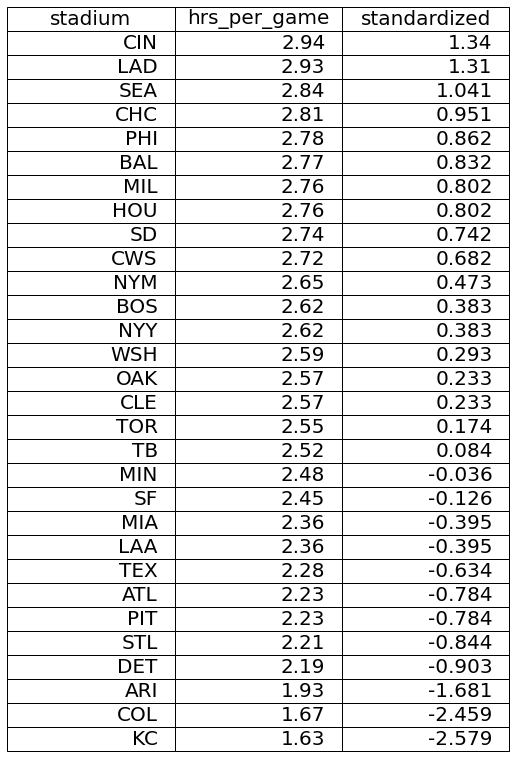

In [73]:
# getting counts of num of hrs in each stadium
all_calc_hrs = calculated_hrs[calculated_hrs['calculated_hr'] == True].copy()
counts = all_calc_hrs.groupby(['stadium'])['calculated_hr'].count().reset_index() 
counts.iloc[29,0] = "WSH"

# getting our counts
counts['adjusted_count'] = counts.apply(lambda row : round(- row['calculated_hr'] / (error_rates[error_rates['stadium'] == row['stadium']].iloc[0,1] - 1)), axis = 1)
counts['hrs_per_game'] = counts.apply(lambda row : round(row['adjusted_count'] / (162 * 15), 2), axis = 1)

# standardizing our values 
mean = counts['hrs_per_game'].mean()
max = counts['hrs_per_game'].max()
min = counts['hrs_per_game'].min()
std = counts['hrs_per_game'].std()
counts['mean_norm'] = counts.apply(lambda row : round((row['hrs_per_game'] - mean) / (max - min), 3), axis = 1)
counts['standardized'] = counts.apply(lambda row : round((row['hrs_per_game'] - mean) / (std), 3), axis = 1)

final_tbl = counts[['stadium','hrs_per_game', 'standardized']]
final_tbl = final_tbl.sort_values(by=['standardized'], ascending=False).copy()

# Plotting

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

#create table
table = ax.table(cellText=final_tbl.values, colLabels=final_tbl.columns, loc='center')

#display table
table.auto_set_font_size(False)
table.set_fontsize(20)
table.scale(1.5, 2)
plt.show()
